# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
def compute_loss_accuracy(model, loader):
    """
    Computes loss and accuracy on the dataset wrapped in a loader
    
    Returns: (average loss, accuracy as a float value between 0 and 1)
    """
    model.eval() # Evaluation mode
    
    loss_accum = 0.0
    correct = 0.0
    total = 0.0
    for i, (x, y) in enumerate(loader):
        y_probs = model(x)        
        y_hat = torch.argmax(y_probs, 1)
        
        loss_value = loss(y_probs, y)
        loss_accum += float(loss_value)
        
        correct += float(torch.sum(y_hat == y))
        total += y.shape[0]
        
    return loss_accum / (i + 1), correct / total

In [29]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, scheduler=None, num_epochs=10, verbosity=0, scheduler_loss=False):        
    train_loss_history = []
    train_acc_history = []

    val_loss_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        if verbosity >= 2:
            if epoch > 0:
                print('')
            
            print('Epoch #%s - optimizer state: %s' % (epoch, optimizer.state_dict()))
        
        loss_accum = 0.0
        correct_samples = 0.0
        total_samples = 0.0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += float(loss_value)

        train_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
                
        val_loss, val_accuracy = compute_loss_accuracy(model, val_loader)
        
        if scheduler is not None:
            if scheduler_loss:
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        
        if verbosity >= 1:
            print("Epoch #%s - train loss: %f, accuracy: %f | val loss: %f, accuracy: %f" % (epoch, train_loss, train_accuracy, val_loss, val_accuracy))
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [11]:
%time train_loss_hh, train_acc_hh, val_loss_hh, val_acc_hh = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs=3, verbosity=1)

Epoch #0 - train loss: 1.335648, accuracy: 0.641624 | val loss: 1.321323, accuracy: 0.647874
Epoch #1 - train loss: 1.325882, accuracy: 0.645326 | val loss: 1.320738, accuracy: 0.645894
Epoch #2 - train loss: 1.321333, accuracy: 0.647852 | val loss: 1.328499, accuracy: 0.639547
CPU times: user 3min 23s, sys: 8min 10s, total: 11min 33s
Wall time: 1min 26s


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [12]:
# Since it's so easy to add layers, let's add some!
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
)
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
%time train_loss_hh, train_acc_hh, val_loss_hh, val_acc_hh = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs=5, verbosity=1)

Epoch #0 - train loss: 2.174083, accuracy: 0.211838 | val loss: 2.078715, accuracy: 0.245034
Epoch #1 - train loss: 1.985721, accuracy: 0.283179 | val loss: 1.891130, accuracy: 0.329875
Epoch #2 - train loss: 1.809995, accuracy: 0.369126 | val loss: 1.746303, accuracy: 0.401474
Epoch #3 - train loss: 1.718483, accuracy: 0.411989 | val loss: 1.696657, accuracy: 0.422838
Epoch #4 - train loss: 1.687574, accuracy: 0.427584 | val loss: 1.674326, accuracy: 0.438195
CPU times: user 5min 31s, sys: 12min 31s, total: 18min 2s
Wall time: 2min 15s


Добавьте слой с Batch Normalization

In [13]:
# We heard batch normalization is powerful, let's use it!
# Add batch normalization after each of the hidden layers of the network, BEFORE or after non-linearity

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    
    nn.Linear(100, 10)
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
%time train_loss_hh, train_acc_hh, val_loss_hh, val_acc_hh = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs=5, verbosity=1)

Epoch #0 - train loss: 2.106274, accuracy: 0.302819 | val loss: 1.868540, accuracy: 0.451232
Epoch #1 - train loss: 1.779410, accuracy: 0.480497 | val loss: 1.686523, accuracy: 0.529588
Epoch #2 - train loss: 1.636567, accuracy: 0.545524 | val loss: 1.565563, accuracy: 0.587059
Epoch #3 - train loss: 1.547526, accuracy: 0.582295 | val loss: 1.494384, accuracy: 0.610675
Epoch #4 - train loss: 1.486827, accuracy: 0.607105 | val loss: 1.434907, accuracy: 0.637021
CPU times: user 6min 5s, sys: 13min 23s, total: 19min 28s
Wall time: 2min 26s


In [14]:
# We heard batch normalization is powerful, let's use it!
# Add batch normalization after each of the hidden layers of the network, before or AFTER non-linearity

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, 100),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    
    nn.Linear(100, 10)
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
%time train_loss_hh, train_acc_hh, val_loss_hh, val_acc_hh = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs=5, verbosity=1)

Epoch #0 - train loss: 1.905807, accuracy: 0.391240 | val loss: 1.613640, accuracy: 0.533069
Epoch #1 - train loss: 1.495128, accuracy: 0.595878 | val loss: 1.379791, accuracy: 0.641390
Epoch #2 - train loss: 1.333397, accuracy: 0.646930 | val loss: 1.251395, accuracy: 0.682001
Epoch #3 - train loss: 1.239541, accuracy: 0.674419 | val loss: 1.231000, accuracy: 0.669647
Epoch #4 - train loss: 1.177291, accuracy: 0.695355 | val loss: 1.124506, accuracy: 0.718518
CPU times: user 5min 56s, sys: 13min 19s, total: 19min 15s
Wall time: 2min 24s


Добавьте уменьшение скорости обучения по ходу тренировки.

In [23]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, 100),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),
    
    nn.Linear(100, 10)
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)
%time train_loss_hh, train_acc_hh, val_loss_hh, val_acc_hh = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs=5, verbosity=2)

Epoch #0 - optimizer state: {'state': {}, 'param_groups': [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.1, 'nesterov': False, 'initial_lr': 0.001, 'params': [140270147425408, 140270147425840, 140270147424400, 140270147424544, 140270147373888, 140270147371728, 140270147371512, 140270147371224, 140270146710048, 140270147289304]}]}
Epoch #0 - train loss: 1.919105, accuracy: 0.385592 | val loss: 1.597818, accuracy: 0.554024

Epoch #1 - optimizer state: {'state': {}, 'param_groups': [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.1, 'nesterov': False, 'initial_lr': 0.001, 'params': [140270147425408, 140270147425840, 140270147424400, 140270147424544, 140270147373888, 140270147371728, 140270147371512, 140270147371224, 140270146710048, 140270147289304]}]}
Epoch #1 - train loss: 1.501598, accuracy: 0.584292 | val loss: 1.372349, accuracy: 0.638455

Epoch #2 - optimizer state: {'state': {}, 'param_groups': [{'lr': 0.0005, 'momentum': 0, 'dampening': 0, 'weight_d

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [16]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    ground_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetSampler(indices))
    
    predictions = []
    ground_truth = []
    for x, y in loader:
        y_probs = model(x)        
        y_hat = torch.argmax(y_probs, 1)
        
        predictions += y_hat.numpy().tolist()
        ground_truth += y.numpy().tolist()
    
    return np.array(predictions), np.array(ground_truth)

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

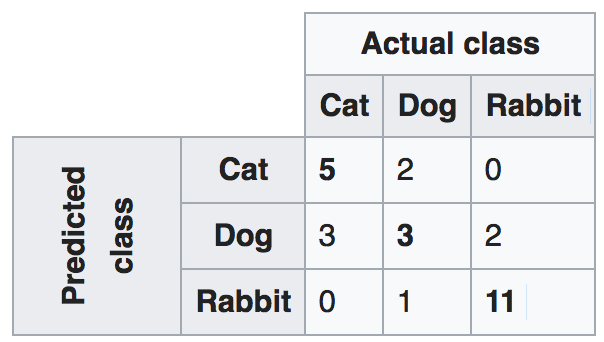

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

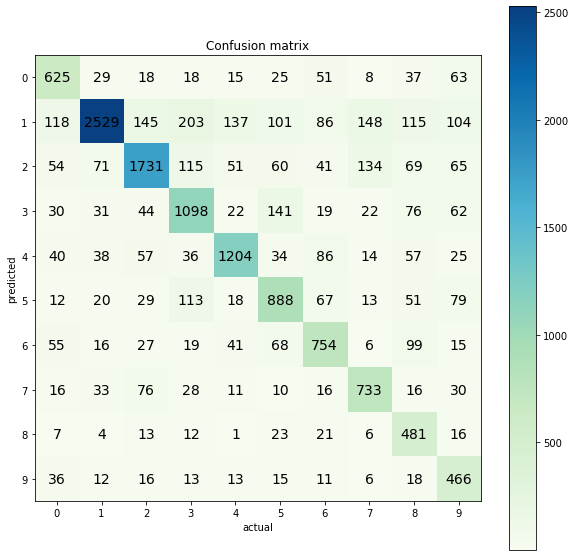

In [17]:
from sklearn import metrics as sk_metrics

def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("actual")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    return sk_metrics.confusion_matrix(ground_truth, predictions).T

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

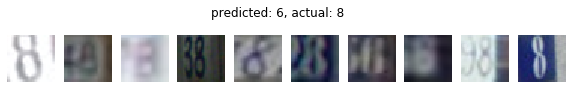

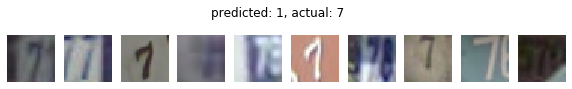

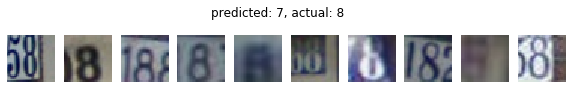

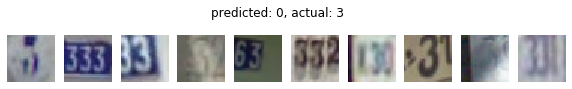

In [18]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):       
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)

        
def visualize_predicted_actual(predicted, actual, predictions, actuals, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    actual: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    actuals: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    title = 'predicted: %s, actual: %s' % (predicted, actual)
    visualize_images(val_indices[(predictions == predicted) & (actuals == actual)], data, title)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(7, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(0, 3, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [36]:
import math

batch_size = 64

layer1 = 100
layer2 = 100

learning_rate = 1e-3
reg_strength = 1e-4

epochs = 30

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, layer1),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer1),
    
    nn.Linear(layer1, layer2),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer2),
    
    nn.Linear(layer2, 10)
)


nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=reg_strength)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3, verbose=True)
%time train_loss_hh, train_acc_hh, val_loss_hh, val_acc_hh = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, \
                                                                         num_epochs=epochs, verbosity=1, scheduler_loss=True)

Epoch #0 - train loss: 1.327690, accuracy: 0.569310 | val loss: 0.976819, accuracy: 0.700840
Epoch #1 - train loss: 0.931705, accuracy: 0.706242 | val loss: 0.848866, accuracy: 0.735308
Epoch #2 - train loss: 0.812379, accuracy: 0.746050 | val loss: 0.758750, accuracy: 0.767934
Epoch #3 - train loss: 0.744690, accuracy: 0.766355 | val loss: 0.688537, accuracy: 0.789366
Epoch #4 - train loss: 0.702847, accuracy: 0.781285 | val loss: 0.709147, accuracy: 0.781039
Epoch #5 - train loss: 0.676419, accuracy: 0.787547 | val loss: 0.664290, accuracy: 0.796191
Epoch #6 - train loss: 0.644348, accuracy: 0.798621 | val loss: 0.644279, accuracy: 0.805133
Epoch #7 - train loss: 0.631324, accuracy: 0.801420 | val loss: 0.629691, accuracy: 0.807795
Epoch #8 - train loss: 0.611959, accuracy: 0.807426 | val loss: 0.618791, accuracy: 0.815917
Epoch #9 - train loss: 0.599746, accuracy: 0.810685 | val loss: 0.632389, accuracy: 0.808068
Epoch #10 - train loss: 0.583974, accuracy: 0.816845 | val loss: 0.640

In [40]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_loss, test_accuracy = compute_loss_accuracy(nn_model, test_loader)
print("Test loss: %f, accuracy: %f" % (test_loss, test_accuracy))

Test loss: 0.614905, accuracy: 0.828019


In [41]:
import math

batch_size = 64

layer1 = 100
layer2 = 100

learning_rate = 1e-3
reg_strength = 1e-4

epochs = 50

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, layer1),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer1),
    
    nn.Linear(layer1, layer2),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer2),
    
    nn.Linear(layer2, 10)
)


nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=reg_strength)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3, verbose=True)
%time train_loss_hh, train_acc_hh, val_loss_hh, val_acc_hh = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, \
                                                                         num_epochs=epochs, verbosity=1, scheduler_loss=True)

Epoch #0 - train loss: 1.323567, accuracy: 0.572245 | val loss: 0.963186, accuracy: 0.700976
Epoch #1 - train loss: 0.934117, accuracy: 0.706617 | val loss: 0.797859, accuracy: 0.752781
Epoch #2 - train loss: 0.814631, accuracy: 0.745743 | val loss: 0.763800, accuracy: 0.765409
Epoch #3 - train loss: 0.746798, accuracy: 0.764785 | val loss: 0.686588, accuracy: 0.791072
Epoch #4 - train loss: 0.704694, accuracy: 0.778163 | val loss: 0.680570, accuracy: 0.792506
Epoch #5 - train loss: 0.672130, accuracy: 0.789151 | val loss: 0.624474, accuracy: 0.810934
Epoch #6 - train loss: 0.650354, accuracy: 0.795260 | val loss: 0.639782, accuracy: 0.805474
Epoch #7 - train loss: 0.628108, accuracy: 0.802853 | val loss: 0.639631, accuracy: 0.803290
Epoch #8 - train loss: 0.611462, accuracy: 0.806556 | val loss: 0.617432, accuracy: 0.809979
Epoch #9 - train loss: 0.601418, accuracy: 0.810804 | val loss: 0.625055, accuracy: 0.809296
Epoch #10 - train loss: 0.592153, accuracy: 0.813842 | val loss: 0.598

In [42]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_loss, test_accuracy = compute_loss_accuracy(nn_model, test_loader)
print("Test loss: %f, accuracy: %f" % (test_loss, test_accuracy))

Test loss: 0.607909, accuracy: 0.832360
